In [308]:
from utils.save_read_graph import read, save
from section3.scenario1 import scenario_1
import seaborn as sns
from tabulate import tabulate


In [210]:
nx.__version__

'2.8.8'

In [5]:
data_path = './data/'
network_path = './networks/p400R400000/'
cn, x, _= read(network_path)
x = {int(k): v for k, v in x.items() }
dfs = scenario_1(cn, x)


  Year    Stations(unit)    Small(%)    Medium(%)    Large(%)  Demand Satisfied(%)      Yearly Profit(M ton)    Construction Cost(M Euro)    Operations Cost(M Euro)
------  ----------------  ----------  -----------  ----------  ---------------------  ----------------------  ---------------------------  -------------------------
  2025                82        75.6         23.2         1.2  not defined                             4.925                          289                       0
  2030               179        34.6         39.7        25.7  96.6                                   32.218                          361                      26.76
  2035               351        28.5         33.9        37.6  not defined                            87.006                          690                      72.76
  2040               387        17.8         26.6        55.6  70.6                                  126.751                          108                     151.52


In [335]:
import networkx as nx
from ortools.linear_solver import pywraplp
def prepare_data(cn, prefix='S3P1'):
    cap_dict = {0:0, 1:1, 2:2, 3:4 }

    n_candidate_site = cn.nodes

    clients = [k for k, v in dict(cn.nodes(data=prefix+"_station_size")).items() if v > 0] 
    d = {i: { j: nx.path_weight(cn, nx.shortest_path(cn, j, i), 'weight')   for j in cn.nodes  if i!= j} for i in clients}
    a = {k:cap_dict[v]  for k, v in dict(cn.nodes(data=prefix+'_station_size')).items() if k in clients}
    return n_candidate_site, clients, d,  a
def PMedian(n_candidate_site, clients, d,  a , p_facilities):

    solver = pywraplp.Solver.CreateSolver('GLOP')
    if not solver:
            return
    Y = {j: solver.BoolVar('y_' + str(j)) for j in n_candidate_site}
    X = {i: {j: solver.BoolVar('x_' + str(i) + '_'+str(j))  for j in   n_candidate_site if j!=i } for i in clients}
    # u = [solver.BoolVar('u_' + str(j)) for j in range(n_candidate_site)]
    # for j in range(len(Y)):
    #     solver.Add(u[j] <= Y[j])
    for i in X:
        solver.Add(sum(list(X[i].values())) == 1)
        for j in X[i]:
            solver.Add(X[i][j] <= 45.6*Y[j] )
    # solver.Add(sum(Y) + sum(u) == p_facilities)
    solver.Add(sum(list(Y.values())) == p_facilities)
    solver.Minimize(sum([sum([ a[i]* d[i][j] *X[i][j] for j in d[i]]) for i in clients])+ 3*sum(list(Y.values())))
    status = solver.Solve()

    # print('\nAdvanced usage:')
    # print('Problem solved in %f milliseconds' % solver.wall_time())
    # print('Problem solved in %d iterations' % solver.iterations())
    # print()
    # print(sum([sum([ a[i]* d[i][j] *X[i][j].solution_value() for j in d[i]]) for i in clients]))
    return {k: {j: v[j].solution_value() for j in v} for k, v in X.items()}, {k: ele.solution_value() for k, ele in Y.items()}






In [395]:
import math
import random
from copy import copy
def algo_by_region(cn, region_name):

    demend_per_region ={k:0 for k in set(dict(cn.nodes(data='region_name')).values())}
    cap_dict = {0:0, 1:1, 2:2, 3:4}
    for i in cn.nodes:
        n = cn.nodes[i]
        demend_per_region[n['region_name']] += cap_dict[n['S3P1_station_size']]

    n_pdl =  cn.subgraph([n for n in cn.nodes if cn.nodes[n]['region_name'] ==  region_name])

    largest_cc = max(nx.connected_components(n_pdl), key=len)
    cn_pdl = n_pdl.subgraph(largest_cc)

    n_candidate_site, clients, d,  a = prepare_data(cn_pdl)
    p = math.floor(demend_per_region[region_name]/ 45.6)
    X, Y_dict= PMedian(n_candidate_site, clients, d,  a, p)
    XY_pair = {k: max(v, key=lambda key: v[key]) for k, v in X.items()}
    station_size = {'large':[], 'small':[]}
    Y = list(Y_dict.values())
    size_coef = list(set(Y))
    size_coef.sort()
    n_large = 0
    n_small = 0
    if len(size_coef) == 3:
        n_large = len([ele for ele in Y if ele >= size_coef[-1]])
        station_size['large'] = [k for k, v in Y_dict.items() if v >= size_coef[-1]]
    elif len(size_coef) == 4:
        n_large = len([ele for ele in Y if ele >= size_coef[-2]])
        station_size['large'] = [k for k, v in Y_dict.items() if v >= size_coef[-2]]

    if demend_per_region[region_name]> n_large*45.6:
        n_small = math.ceil((demend_per_region[region_name] - n_large*45.6)/2) 
        if len(size_coef) == 3:
            station_size['small'] = random.choices( [k for k, v in Y_dict.items() if (v>0) and (v < size_coef[-1])], k=n_small)
        elif len(size_coef) == 4:
            station_size['small'] = random.choices( [k for k, v in Y_dict.items() if (v>0) and (v < size_coef[-2])], k=n_small)
    XY_transportation = {}
    for n,s in XY_pair.items():
       
        if (s not in  station_size['small'] ) and (s not in  station_size['large'] ):
            dist = {}
            for potential_st in station_size['small'] + station_size['large']:
                dist[potential_st] =  nx.shortest_path(cn, potential_st, n)
            s =  max(dist, key=lambda key: dist[key])
        XY_transportation[n] = nx.path_weight(cn, nx.shortest_path(cn, s, n) , 'weight') / 1000 *cn.nodes[n]['S3P1_station_size'] *8
         

    supply_demand_ratio = (45.6 * n_large + 2 * n_small) /demend_per_region[region_name]
    return station_size, [region_name, len(station_size['large']), len(station_size['small']), f'{supply_demand_ratio:.3f}', 20*n_small+120*n_large, f'{sum(XY_transportation.values())/1000:.1f}']

In [396]:
algo_by_region(cn, 'Grand Est')

({'large': [602, 363],
  'small': [24,
   333,
   713,
   283,
   457,
   741,
   333,
   144,
   646,
   24,
   536,
   357,
   676,
   144,
   283,
   390,
   98,
   185,
   261,
   183]},
 ['Grand Est', 2, 20, '1.002', 640, '53.3'])

In [397]:
table = []
station_size_all = {'large':[], 'small':[]}
for r in set(dict(cn.nodes(data='region_name')).values()):
    station_size_r, statistics = algo_by_region(cn, r)
    station_size_r, statistics = algo_by_region(cn, r)
    station_size_all['large'] += station_size_r['large']
    station_size_all['small'] += station_size_r['small']

    table.append(statistics)



In [393]:
header = ['Region','Large Plant(unit)','Small Plant(unit)'
        ,'Supply to Demand(%)', 'Construction cost(M Euro)'
        , 'Transportation cost (k Euro/yr)']
print (tabulate(table, headers=header))


Region                        Large Plant(unit)    Small Plant(unit)    Supply to Demand(%)    Construction cost(M Euro)    Transportation cost (k Euro/yr)
--------------------------  -------------------  -------------------  ---------------------  ---------------------------  ---------------------------------
Bourgogne-Franche-Comté                       2                    2                  1.013                          280                               39.7
Provence-Alpes-Côte d'Azur                    1                   11                  1.009                          340                               19
Centre-Val de Loire                           2                    6                  1.002                          360                               38.1
Bretagne                                      1                   13                  1.008                          380                               22.3
Nouvelle-Aquitaine                            3                   

In [215]:
set(Y)

{0.0, 0.021929824561403508, 0.4736842105263159, 1.0}

In [184]:
len([ele for ele in Y if ele>0.02])
# len([ele for ele in Y if ele==1])

26

In [185]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_network_with_stations_size(roads, station_sizes_prod):
    edges, weights = zip(*nx.get_edge_attributes(roads, "traffic flow").items())
    weights = np.array(weights) + 1
    weights = np.log(weights)
    is_OD = np.array(list(dict(roads.nodes(data="S3P1_station_size")).values()))
    # is_nor = np.array(list(dict(roads.nodes(data='region_name')).values() ))
    cluster_centers = dict(roads.nodes(data="coordinates"))
    is_station = np.zeros(len(roads.nodes))
    
 
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))

    node_color = ["red" if n else "blue" for n in is_OD]
    for ind in roads.nodes:
        if ind in station_sizes_prod['large']:
            node_color[ind] = "green"
            is_station[ind] = 1
        elif ind in station_size_prod['small']:
            node_color[ind] = "purple"
            is_station[ind] = 1
        
    print()
    options = {
        "edge_color": weights,
        "width": 4,
        "edge_cmap": plt.cm.Wistia,
        "with_labels": False,
        "node_color": node_color,
        "node_size": (is_OD/5 + np.array(y)) * 20,
    }
    nx.draw(
        roads,
        pos=cluster_centers,
        **options,
    )

    plt.show()



We allocate 2 stations in this network



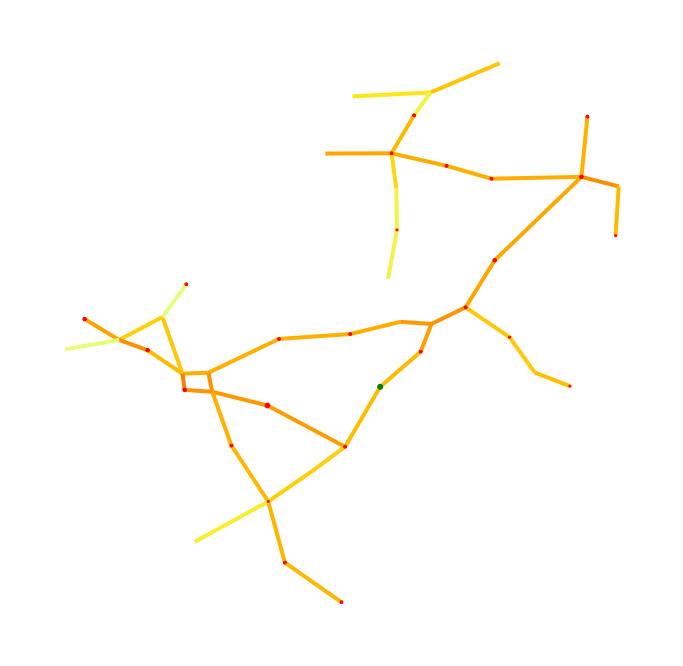

In [186]:
visualize_network_with_stations_size(cn_pdl, [ele if ele>0.025 else 0 for ele in Y ])

In [101]:
factory_size={}
for i in range(len(Y)):
    if Y[i] > 0.03:
        factory_size[i] = 2

    else:
        factory_size[i] = 0

In [102]:
nx.set_node_attributes(cn, 0, "S4_factory_size")
nx.set_node_attributes(cn, factory_size, "S4_factory_size")

In [103]:
capacity_per_region ={k:0 for k in set(dict(cn.nodes(data='region_name')).values())}
prod_cap_dict = {0:0, 1:2, 2:45.6}
for i in cn.nodes:
    n = cn.nodes[i]
    capacity_per_region[n['region_name']] += prod_cap_dict[n['S4_factory_size']]

In [195]:
header = ['BFC', 'Prov.', 'CDL', 'Bret.', 'NA', 'PDL', 'HDF', 'Norm.', 'IDF', 'ARA', 'GE', 'Occit.']
abbriv = {
    'BFC':'Bourgogne-Franche-Comté',
    'Prov.':"Provence-Alpes-Côte d'Azur",
    'CDL':'Centre-Val de Loire',
    'Bret.': 'Bretagne',
    'NA': 'Nouvelle-Aquitaine',
    'PDL': 'Pays de la Loire',
    'HDF': 'Hauts-de-France',
    'Norm.': 'Normandie',
    'IDF': 'Île-de-France',
    'ARA': 'Auvergne-Rhône-Alpes',
    'GE': 'Grand Est',
    'Occit.':'Occitanie'
}
res = [demend_per_region[abbriv[name]] for name in header]

Text(0, 0.5, 'Demend t/d')

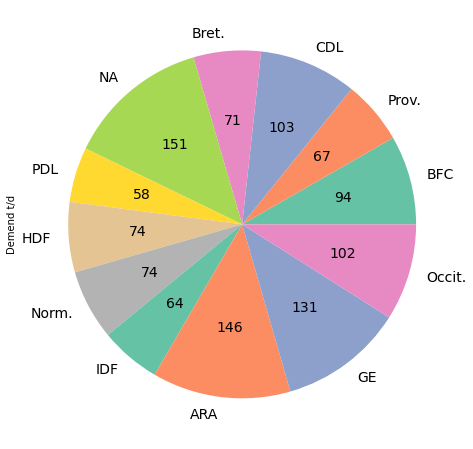

In [208]:
fig, axs = plt.subplots( figsize=(8,8))
axs.pie(res, labels=header,autopct=lambda x: '{:.0f}'.format(x*sum(res)/100) ,textprops={'fontsize': 14},colors=sns.color_palette('Set2'))
axs.tick_params(axis='x', rotation=45)
axs.set_ylabel("Demend t/d")


In [104]:
capacity_per_region

{'Bourgogne-Franche-Comté': 228.0,
 "Provence-Alpes-Côte d'Azur": 0,
 'Centre-Val de Loire': 273.6,
 'Bretagne': 91.2,
 'Nouvelle-Aquitaine': 364.80000000000007,
 'Pays de la Loire': 0,
 'Hauts-de-France': 273.6,
 'Normandie': 91.2,
 'Île-de-France': 91.2,
 'Auvergne-Rhône-Alpes': 182.4,
 'Grand Est': 182.4,
 'Occitanie': 45.6}